# Load Dataset

We scale the x,y coordinates to be within the unit square.
For entries that did not have capacity, we randomly sample without replacement from the distribution of reported capacitites.

Before the coordinate transformation, a distance of ~540 is roughly 10 min walk. (what units are these coordinates? I estimated this by just picking two hotels and looking at google maps)

DC Office of the Chief Technology Officer (OCTO). "Hotels." ArcGIS Hub. Accessed February 17, 2026. https://hub.arcgis.com/datasets/DCGIS::hotels/about. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

df = pd.read_csv('Hotels.csv')
coord = df[['XCOORD', 'YCOORD']].values
capacities = np.array(df[['NUMROOMS']].values).flatten()

# scale the x,y coordinates to be within the unit square.
scale = max(np.max(coord[:, 0]) - np.min(coord[:, 0]), np.max(coord[:, 1]) - np.min(coord[:, 1]))
print(scale)
coord[:,0] = (coord[:,0] - np.min(coord[:,0]))/scale
coord[:,1] = (coord[:,1] - np.min(coord[:,1]))/scale

# For entries that did not have capacity, we randomly sample without replacement from the distribution of reported capacitites
permuted_capacities = np.random.permutation(capacities[~np.isnan(capacities)])
print(permuted_capacities[0:np.sum(np.isnan(capacities))])
capacities[np.isnan(capacities)] = permuted_capacities[0:np.sum(np.isnan(capacities))]

15276.539999999979
[327.  43.   8.  99. 346. 204. 204.   5.  53. 836. 152.  96. 541. 149.
  12. 336.  95. 222. 832. 195.  15. 134.  40. 146. 126. 185. 222. 114.]


We plot the distribution of the ground truth capacities (including the artificially filled in capacities).

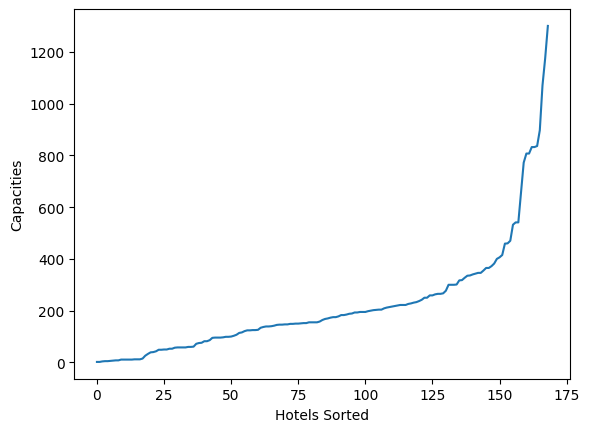

In [44]:
sorted_arr = np.sort(capacities)
plt.plot(sorted_arr)
plt.xlabel('Hotels Sorted')
plt.ylabel('Capacities')
plt.show()


We plot the locations of the hotels with the colors given by the capacities.

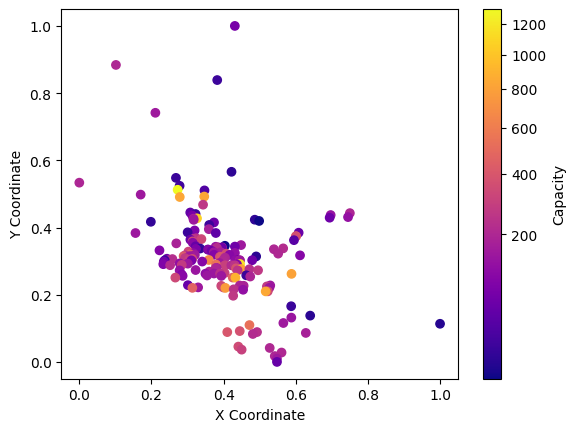

In [45]:
norm = colors.PowerNorm(gamma=0.5, vmin=capacities.min(), vmax=capacities.max())
plt.scatter(coord[:,0], coord[:,1], c=capacities, cmap='plasma', norm=norm)
plt.colorbar(label='Capacity')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


We make the capacities coarser, setting them to ceiling(capacity / 50).

In [46]:
capacities = np.ceil(capacities / 50)

## 1. Model <a id='sec1'></a> 
We will use a linear reward function
$$\mu_{it}(S_{it}): = E[Y_{it} \mid S_{it}, W] = b_{it} + a_{it} \frac {S_{it}} m.$$
We divide by $m$ to normalize. The state evolves as a clipped random walk with states $\{0,1,...,m\}$. Specifially, define *competition level* as the proportion of neighbors assigned arm $1$, formally,  
$$C_{it} = \frac{\sum_{j\in {\cal N}(i)\backslash i}W_{jt}}{|{\cal N}(i)\backslash i|}.$$
The probability of going up conditional on non-lazy event is 
$$P^{\rm up}_{it} = \sigma(\alpha_{it} + \beta_{it}W_{it} - \gamma_{it} C_{it})$$
(expect at the ceiling), where $\sigma$ is the sigmod function.
Accounting for the laziness $L\in [0,1]$, the probability of going up is then 
$$(1-L)\cdot P^{\rm up}_{it}.$$
Assume that $\gamma_{it} \leq \beta_{it}$ such that under full treatment the net effect is still positive.
For a given $\delta$, the exposure mapping is computed as the joint of $W_{it} = a$ AND at least $(1-\delta)$ fraction of its spatiotemporal neighbors excluding $(i,t)$ itself have treatment equal to $a$.